In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols # Creating linear model
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Read the dataset
credit = pd.read_csv('c:/GL Class/Industry Session/4th Dec 2021/credit_card.csv')

In [3]:
credit.head()

,ID,BALLIMIT,GENDER,EDUCATION,MARITAL_S,AGE,PAYSEPFL,PAYAUGFL,PAYJULFL,PAYJUNEFL,...,BILLJUNE,BILLMAY,BILLAPR,PAYSEP,PAYAUG,PAYJUL,PAYJUNE,PAYMAY,PAYAPR,DEFAULT
0,1,20000,Female,University,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,Female,University,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,Female,University,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,Female,University,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,Male,University,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Let's start with calculating WOE and IV

In [4]:
credit['AGE_CAT'] = pd.cut(credit['AGE'], bins=[0,25,34,44,100],labels=["0-25","26-34","36-44","44+"])


In [5]:
pd.crosstab(credit.AGE_CAT,credit.DEFAULT)

DEFAULT,0,1
AGE_CAT,,
0-25,2839,1032
26-34,9486,2339
36-44,7047,1971
44+,3992,1294


       Event	Non Event	%Event	% Non Event   	WOE         IV
0-25	1032	2839	0.155515371	0.121511727	-0.246733793	0.008389848
26-34	2339	9486	0.352471368	0.406009245	0.141406536 	0.007570606
36-44	1971	7047	0.297016275	0.301617874	0.015373962	    7.07448E-05
44+  	1294	3992	0.194996986	0.170861154	-0.132132841	0.003189136
        6636	23364				
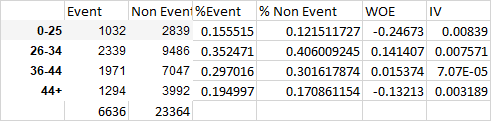

Summation of IV is 0.019220334

    
Information Value	Predictive power
<0.02	Useless
0.02 to 0.1	Weak predictors
0.1 to 0.3	Medium Predictors
0.3 to 0.5	Strong predictors
>0.5	Suspicious

## Model Building

In [6]:
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.preprocessing import StandardScaler # for normalization

In [7]:
credit=credit.drop('AGE_CAT', axis=1)

In [8]:
credit=credit.drop('ID', axis=1)

In [9]:
credit['GENDER'] = pd.Categorical(credit['GENDER'])
credit['GENDER']= credit.GENDER.cat.codes
credit['MARITAL_S'] = pd.Categorical(credit['MARITAL_S'])
credit['MARITAL_S']=credit.MARITAL_S.cat.codes
credit['EDUCATION'] = pd.Categorical(credit['EDUCATION'])
credit['EDUCATION']=credit.EDUCATION.cat.codes

### Original dataset

In [10]:
# Original dataset
X = credit.drop('DEFAULT', axis=1)  
y = credit['DEFAULT']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# Separating features and target
y = credit.DEFAULT     # target default=1 or non-default=0
features = credit.drop('DEFAULT', axis = 1, inplace = False)

In [12]:
features.GENDER =pd.Categorical(features['GENDER'])
features['GENDER'] = features.GENDER.cat.codes
features['MARITAL_S'] =pd.Categorical(features['MARITAL_S'])
features['MARITAL_S']= features.MARITAL_S.cat.codes
features['EDUCATION'] =pd.Categorical(features['EDUCATION'])
features['EDUCATION'] =features.EDUCATION.cat.codes
features.head()

,BALLIMIT,GENDER,EDUCATION,MARITAL_S,AGE,PAYSEPFL,PAYAUGFL,PAYJULFL,PAYJUNEFL,PAYMAYFL,...,BILLJUL,BILLJUNE,BILLMAY,BILLAPR,PAYSEP,PAYAUG,PAYJUL,PAYJUNE,PAYMAY,PAYAPR
0,20000,0,3,0,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,0,3,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,0,3,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,0,3,0,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,3,0,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [13]:
stdX = (features - features.mean()) / (features.std())   

In [14]:
stdX.head()

,BALLIMIT,GENDER,EDUCATION,MARITAL_S,AGE,PAYSEPFL,PAYAUGFL,PAYJULFL,PAYJUNEFL,PAYMAYFL,...,BILLJUL,BILLJUNE,BILLMAY,BILLAPR,PAYSEP,PAYAUG,PAYJUL,PAYJUNE,PAYMAY,PAYAPR
0,-1.136701,-0.810147,0.988618,-1.086867,-1.245999,1.794534,1.782318,-0.696652,-0.666588,-1.530021,...,-0.667982,-0.672486,-0.663047,-0.652713,-0.341936,-0.227082,-0.296796,-0.308057,-0.314131,-0.293377
1,-0.365974,-0.810147,0.988618,0.925042,-1.029030,-0.874977,1.782318,0.138862,0.188743,0.234913,...,-0.639244,-0.621626,-0.606219,-0.597956,-0.341936,-0.213584,-0.240001,-0.244226,-0.314131,-0.180875
2,-0.597192,-0.810147,0.988618,0.925042,-0.161154,0.014860,0.111734,0.138862,0.188743,0.234913,...,-0.482400,-0.449723,-0.417181,-0.391623,-0.250287,-0.191884,-0.240001,-0.244226,-0.248679,-0.012122
3,-0.905483,-0.810147,0.988618,-1.086867,0.164300,0.014860,0.111734,0.138862,0.188743,0.234913,...,0.032846,-0.232369,-0.186726,-0.156576,-0.221187,-0.169358,-0.228641,-0.237842,-0.244162,-0.237126
4,-0.905483,1.234302,0.988618,-1.086867,2.333990,-0.874977,0.111734,-0.696652,0.188743,0.234913,...,-0.161186,-0.346991,-0.348131,-0.331476,-0.221187,1.335012,0.271161,0.266429,-0.269034,-0.255183


### Dataset with standardized features

In [15]:
# Dataset with standardized features
Xstd_train, Xstd_test, ystd_train, ystd_test = train_test_split(stdX,y, test_size=0.2, stratify=y,
                                                                random_state=42)

## Feature selection

In [16]:
NUM_FEATURES = 3
model = LogisticRegression()
rfe_stand = RFE(model, NUM_FEATURES)
fit_stand = rfe_stand.fit(stdX, y)
#print("St Model Num Features:", fit_stand.n_features_)
#print("St Model Selected Features:", fit_stand.support_)
print("Std Model Feature Ranking:", fit_stand.ranking_)
# calculate the score for the selected features
score_stand = rfe_stand.score(stdX,y)
print("Standardized Model Score with selected features is: %f (%f)" % (score_stand.mean(), score_stand.std()))

Std Model Feature Ranking: [ 8 10 15  7 16  1  6  4 19 13 20  1  5  2 21 11 18  3  1 12  9 14 17]
Standardized Model Score with selected features is: 0.812600 (0.000000)


In [17]:
feature_names = np.array(features.columns)
print('Most important features (RFE): %s'% feature_names[rfe_stand.support_])

Most important features (RFE): ['PAYSEPFL' 'BILLSEP' 'PAYAUG']


In [18]:
# Dataset with three most important features
Ximp = stdX[['PAYSEPFL', 'BILLSEP', 'PAYAUG']]
X_tr, X_t, y_tr, y_t = train_test_split(Ximp,y, test_size=0.2, stratify=y, random_state=42)

In [19]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

###  Hyper Parameter Tuning

In [20]:
## Model with the original dataset - without standardised features

In [21]:
# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Tuned Logistic Regression Parameters: {'C': 0.0007196856730011522}


Accuracy: 0.7788333333333334

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000


Average 5-Fold CV Score: 0.7787 , Standard deviation: 0.0001


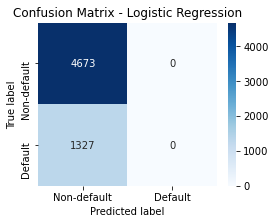

In [22]:
LR = LogisticRegression(C=0.051, random_state=0)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred,y_test))
## 5-fold cross-validation 
cv_scores =cross_val_score(LR, X, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression");

- Zero prediction power of the model... Important observation

In [23]:
# Setup the hyperparameter grid, (Scaled Data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(Xstd_train, ystd_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Tuned Logistic Regression Parameters: {'C': 3.727593720314938}


Accuracy: 0.8091666666666667

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.70      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000


Average 5-Fold CV Score: 0.8099 , Standard deviation: 0.0045


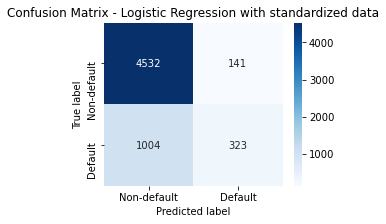

In [24]:
LRS = LogisticRegression(C=3.73, random_state=0)
LRS.fit(Xstd_train, ystd_train)
y_pred = LRS.predict(Xstd_test)
print('Accuracy:', metrics.accuracy_score(y_pred,ystd_test))

## 5-fold cross-validation 
cv_scores =cross_val_score(LRS, stdX, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(ystd_test, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(ystd_test,LRS.predict(Xstd_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression with standardized data");

In [25]:
# Setup the hyperparameter grid, (Only with important feature on standardised dataset)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(X_tr, y_tr)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

Tuned Logistic Regression Parameters: {'C': 3.727593720314938}


Accuracy: 0.8121666666666667

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.27      0.39      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.62      0.64      6000
weighted avg       0.79      0.81      0.78      6000


Average 5-Fold CV Score: 0.8118 , Standard deviation: 0.0065


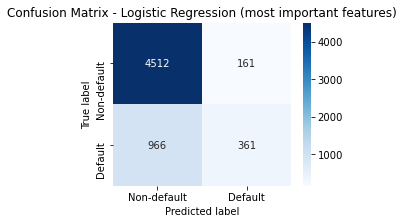

In [26]:
LR_imp = LogisticRegression(C=3.73, random_state=0)
LR_imp.fit(X_tr, y_tr)
y_pred = LR_imp.predict(X_t)
print('Accuracy:', metrics.accuracy_score(y_pred,y_t))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR_imp, Ximp, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_t, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_t,LR_imp.predict(X_t))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (most important features)");

- 3 Important Features have increased the recall for defaulters..

## Feature Enginnering

### Feature # 1

In [27]:
# Payment status columns which have 0 or greater value are more prone to become a defaulter. 
# Let's sum all the Pay status and then look at the distribution for the Defaulter and non defaulter.
credit['RISK_VALUE'] = credit['PAYAPRFL'] + credit['PAYMAYFL'] + credit['PAYJUNEFL'] + credit['PAYJULFL'] + credit['PAYAUGFL'] + credit['PAYSEPFL']

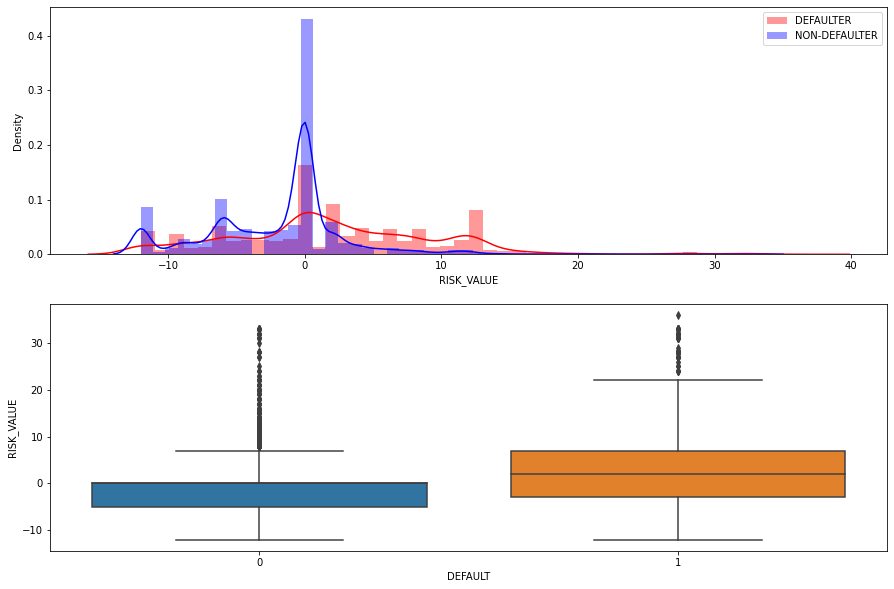

In [28]:
# Let's look at the distribution of the above feature created
plt.figure(figsize = (15,10))
# distribution plot
plt.subplot(211)
sns.distplot(credit[credit['DEFAULT']==1]['RISK_VALUE'], color = 'r', label = 'DEFAULTER')
sns.distplot(credit[credit['DEFAULT']==0]['RISK_VALUE'], color = 'b', label = 'NON-DEFAULTER')
plt.legend()
# boxplot
plt.subplot(212)
sns.boxplot(credit['DEFAULT'], credit['RISK_VALUE'])
plt.show()

- It can be seen that the values which are greater than 0 have more chances of being defaulter. It is quite separable.

In [29]:
# Let's check this new column affiliation with the columns with which it was created so we will drop those columns 
# and move only with this column
# Let's build a Linear model to check the statistics
model = ols('RISK_VALUE~PAYAPRFL+PAYMAYFL+PAYJUNEFL+PAYJULFL+PAYAUGFL+PAYSEPFL', data = credit).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             RISK_VALUE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.424e+32
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:19:04   Log-Likelihood:             9.1178e+05
No. Observations:               30000   AIC:                        -1.824e+06
Df Residuals:                   29993   BIC:                        -1.823e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.504e-15    9.2e-17     38.099      0.000    3.32e-15    3.68e-15
PAYAPRFL       1.0000   1.36e-16   7.37e+15      0.000       1.000       1.000
PAYMAYFL       1.0000   1.67e-16   5.99e+15      0.000       1.000       1.000
PAYJUNEFL      1.0000   1.55e-16   6.47e+15      0.000       1.000       1.000
PAYJULFL       1.0000   1.39e-16   7.18e+15      0.000       1.000       1.000
PAYAUGFL       1.0000   1.29e-16   7.73e+15      0.000       1.000       1.000
PAYSEPFL       1.0000   1.08e-16   9.26e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                     4406.109   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18018.996
Skew:                          -0.684   Prob(JB):                         0.00
Kurtosis:                       6.541   Cond. No.                         5.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Drop all Pay Flags Features

In [30]:
pd.set_option('display.max_columns', 500)
pd.DataFrame(credit.groupby('DEFAULT')['RISK_VALUE'].value_counts()).T

DEFAULT        0                                                             \
RISK_VALUE    0    -6    -12    2    -1   -4   -2   -5   -3   -9   -7    3    
RISK_VALUE  9062  2139  1825  1248  1143  980  917  898  882  605  533  426   

DEFAULT                                                                       \
RISK_VALUE  -8    4   -10   5    6    1    8    7    12   11  9  -11  10  13   
RISK_VALUE  411  378  242  231  231  201  172  170  148  147  93  71  61  33   

DEFAULT                                                                     \
RISK_VALUE  14  20  15  16  33  18  21  22  17  32  19  28  31  23  24  27   
RISK_VALUE  29  13  11  11   8   7   6   6   5   4   3   3   3   2   2   2   

DEFAULT                1                                                    \
RISK_VALUE  25  30    0    2    12  -6    4    6    8   -12  -9    3   -1    
RISK_VALUE   1   1  1130  635  453  357  339  319  315  284  262  227  195   

DEFAULT                                                                      \
RISK_VALUE  -4   -3    11   7    5   -2   -5    13   10  1  -7   9  -8  -10   
RISK_VALUE  183  179  176  173  168  167  163  112  100  97  93  93  78  51   

DEFAULT                                                                     \
RISK_VALUE  14  15  16  28  17 -11  32  18  20  33  27  19  31  21  24  22   
RISK_VALUE  50  44  37  24  20  17  16  15  13  11  10   8   6   4   4   3   

DEFAULT                     
RISK_VALUE  25  26  29  36  
RISK_VALUE   2   1   1   1

- As we can see clearly that for NON_DEFAULTERS most values are negative or 0.
- For DEFAULTERS most values are greater than 0.

### Feature # 2

In [31]:
# Sum of average bill amounts for all the months divide by 6
credit['BILL_VALUE'] = (credit['BILLAPR'] + credit['BILLMAY'] + credit['BILLJUNE'] + credit['BILLJUL']
                        + credit['BILLAUG'] + credit['BILLSEP'])/6

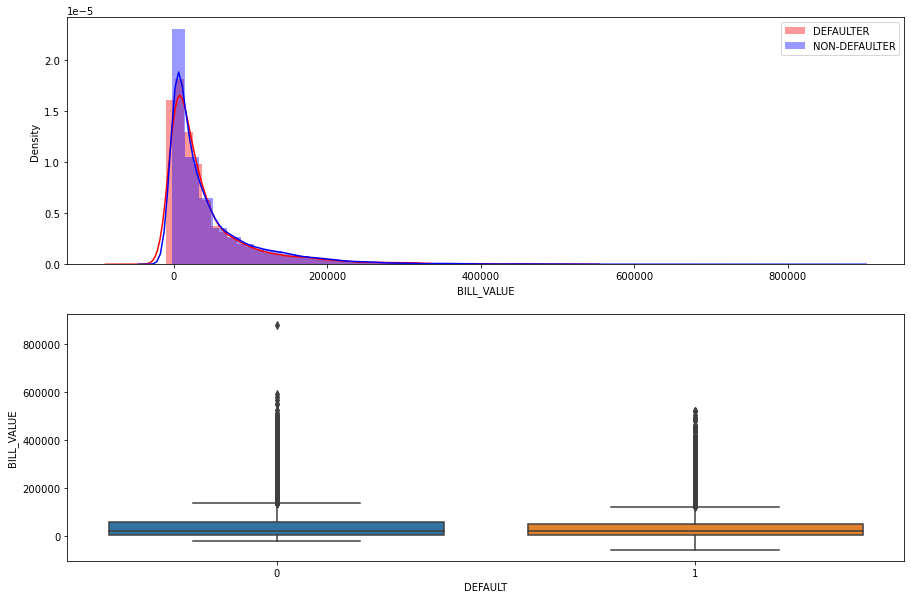

In [32]:
# Let's look at the distribution of the above feature created
plt.figure(figsize = (15,10))
# distribution plot
plt.subplot(211)
sns.distplot(credit[(credit['DEFAULT']==1)]['BILL_VALUE'], color = 'r', label = 'DEFAULTER')
sns.distplot(credit[(credit['DEFAULT']==0)]['BILL_VALUE'], color = 'b', label = 'NON-DEFAULTER')
plt.legend()
# boxplot
plt.subplot(212)
sns.boxplot(credit['DEFAULT'], credit['BILL_VALUE'])
plt.show()


In [33]:
credit[credit['BILL_VALUE']<0]['DEFAULT'].value_counts()

0    150
1     51
Name: DEFAULT, dtype: int64

- People with High negative value of BILL_VALUE are definitely defaulters.

### Feature # 3

In [34]:
# subtracting the payment of this month to previous month's BILL
credit['BILL_PAY_VALUE'] = ((credit['PAYSEP'] - credit['BILLAUG']) + 
                            (credit['PAYAUG'] - credit['BILLJUL']) +
                           (credit['PAYJUL'] - credit['BILLJUNE']) +
                           (credit['PAYJUNE'] - credit['BILLMAY']) + 
                           (credit['PAYMAY'] - credit['BILLAPR']))/5

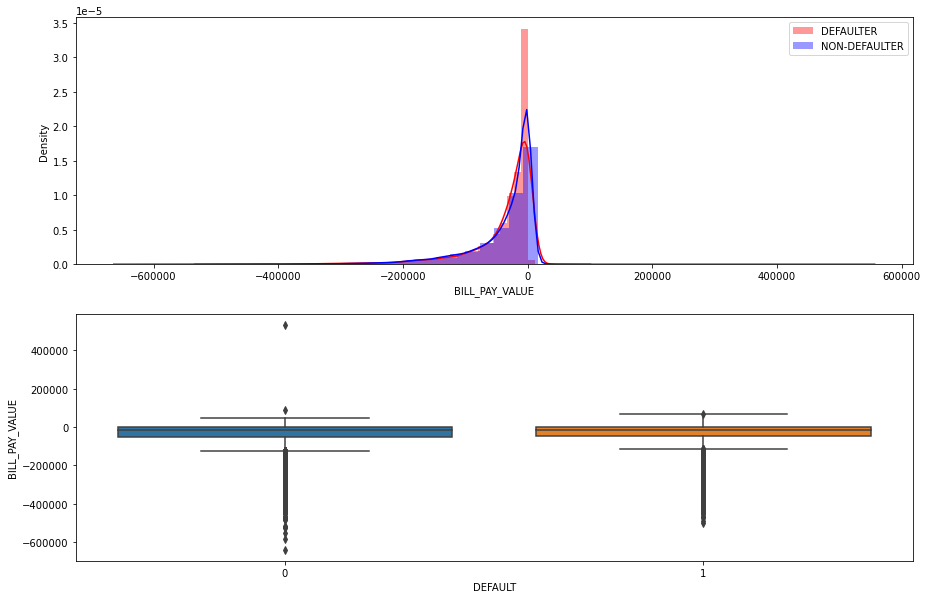

In [35]:
# Let's look at the distribution of the above feature created
plt.figure(figsize = (15,10))
# distribution plot
plt.subplot(211)
sns.distplot(credit[credit['DEFAULT']==1]['BILL_PAY_VALUE'], color = 'r', label = 'DEFAULTER')
sns.distplot(credit[credit['DEFAULT']==0]['BILL_PAY_VALUE'], color = 'b', label = 'NON-DEFAULTER')
plt.legend()
# boxplot
plt.subplot(212)
sns.boxplot(credit['DEFAULT'], credit['BILL_PAY_VALUE'])
plt.show()

In [36]:
credit[credit['BILL_PAY_VALUE']>0]['DEFAULT'].value_counts()

0    3041
1     430
Name: DEFAULT, dtype: int64

- People with positive Pay value are more likely to default. # This is one important feature as this has almost no defaulters on the negative side. The people who pay more than their bill are more likely to not default.

### Feature # 4

In [37]:
# Sum of PAY amounts for all the months divide by Limit balance
credit['PAY_VALUE'] = (credit['PAYAPR'] + credit['PAYMAY'] + credit['PAYJUNE'] + credit['PAYJUL']
                        + credit['PAYAUG'] + credit['PAYSEP'])/6

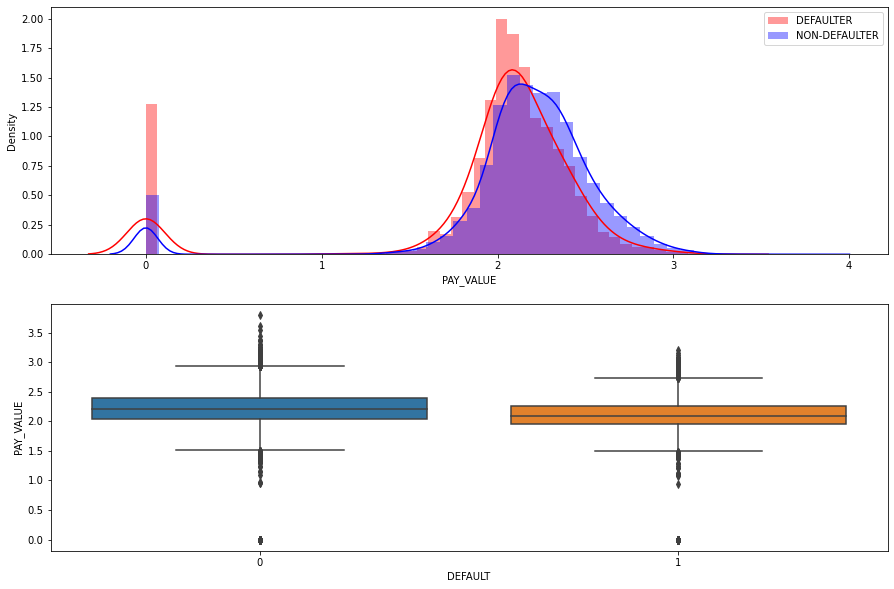

In [38]:
# Let's look at the distribution of the above feature created
plt.figure(figsize = (15,10))
# distribution plot
plt.subplot(211)
sns.distplot((credit[credit['DEFAULT']==1]['PAY_VALUE'])**0.1, color = 'r', label = 'DEFAULTER')
sns.distplot((credit[credit['DEFAULT']==0]['PAY_VALUE'])**0.1, color = 'b', label = 'NON-DEFAULTER')
plt.legend()
# boxplot
plt.subplot(212)
sns.boxplot(credit['DEFAULT'], (credit['PAY_VALUE'])**0.1)
plt.show()

- Not much separated so should not use it.
- But we can segment our modelling process for the one which have 0 value and other.

## Model after including Feature # 1

In [39]:
Ximp.head()

,PAYSEPFL,BILLSEP,PAYAUG
0,1.794534,-0.642490,-0.227082
1,-0.874977,-0.659208,-0.213584
2,0.014860,-0.298555,-0.191884
3,0.014860,-0.057490,-0.169358
4,-0.874977,-0.578608,1.335012


In [40]:
Ximp['RISK_VALUE'] = (credit.RISK_VALUE - credit.RISK_VALUE.mean()) / (credit.RISK_VALUE.std())  

In [41]:
Ximp.head()

,PAYSEPFL,BILLSEP,PAYAUG,RISK_VALUE
0,1.794534,-0.642490,-0.227082,-0.153633
1,-0.874977,-0.659208,-0.213584,0.694823
2,0.014860,-0.298555,-0.191884,0.185750
3,0.014860,-0.057490,-0.169358,0.185750
4,-0.874977,-0.578608,1.335012,-0.153633


In [42]:
X_tr, X_t, y_tr, y_t = train_test_split(Ximp,y, test_size=0.2, stratify=y, random_state=42)

In [43]:
# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(X_tr, y_tr)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))

Tuned Logistic Regression Parameters: {'C': 3.727593720314938}


Accuracy: 0.8108333333333333

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.71      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.77      0.61      0.63      6000
weighted avg       0.80      0.81      0.77      6000


Average 5-Fold CV Score: 0.8095 , Standard deviation: 0.005


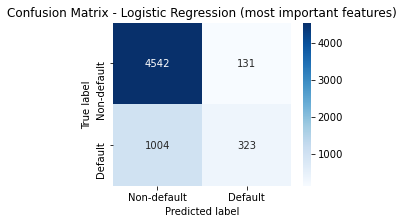

In [44]:
LR_imp = LogisticRegression(C=3.73, random_state=0)
LR_imp.fit(X_tr, y_tr)
y_pred = LR_imp.predict(X_t)
print('Accuracy:', metrics.accuracy_score(y_pred,y_t))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR_imp, Ximp, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_t, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_t,LR_imp.predict(X_t))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (most important features)");

## Model after including Feature # 3

In [45]:
Ximp.head()

,PAYSEPFL,BILLSEP,PAYAUG,RISK_VALUE
0,1.794534,-0.642490,-0.227082,-0.153633
1,-0.874977,-0.659208,-0.213584,0.694823
2,0.014860,-0.298555,-0.191884,0.185750
3,0.014860,-0.057490,-0.169358,0.185750
4,-0.874977,-0.578608,1.335012,-0.153633


In [46]:
Ximp['BILL_PAY_VALUE'] = (credit.BILL_PAY_VALUE - credit.BILL_PAY_VALUE.mean()) / (credit.BILL_PAY_VALUE.std())  

In [47]:
Ximp=Ximp.drop(['RISK_VALUE'],axis=1)

In [48]:
Ximp.head()

,PAYSEPFL,BILLSEP,PAYAUG,BILL_PAY_VALUE
0,1.794534,-0.642490,-0.227082,0.637006
1,-0.874977,-0.659208,-0.213584,0.609070
2,0.014860,-0.298555,-0.191884,0.423793
3,0.014860,-0.057490,-0.169358,0.051359
4,-0.874977,-0.578608,1.335012,0.504788


In [49]:
X_tr, X_t, y_tr, y_t = train_test_split(Ximp,y, test_size=0.2, stratify=y, random_state=42)

In [50]:
# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg,param_grid , cv=5, random_state=0)

# Fit it to the data
logreg_cv.fit(X_tr, y_tr)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))

Tuned Logistic Regression Parameters: {'C': 268.2695795279727}


Accuracy: 0.8145

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      4673
           1       0.70      0.28      0.40      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.62      0.65      6000
weighted avg       0.80      0.81      0.78      6000


Average 5-Fold CV Score: 0.8124 , Standard deviation: 0.0061


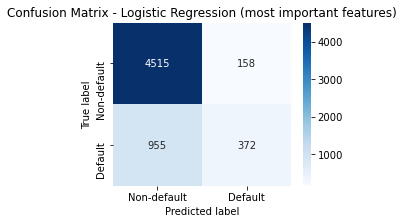

In [51]:
LR_imp = LogisticRegression(C=268.27, random_state=0)
LR_imp.fit(X_tr, y_tr)
y_pred = LR_imp.predict(X_t)
print('Accuracy:', metrics.accuracy_score(y_pred,y_t))

## 5-fold cross-validation 
cv_scores =cross_val_score(LR_imp, Ximp, y, cv=5)

# Print the 5-fold cross-validation scores
print()
print(classification_report(y_t, y_pred))
print()
print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard deviation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_t,LR_imp.predict(X_t))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (most important features)");

- Recall has further increased.. So this is definitely a significant feature

## Cluster to understand class segregation

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [53]:
raw_df = credit.drop('GENDER', axis = 1) 
raw_df = raw_df.drop('EDUCATION', axis = 1) 
raw_df = raw_df.drop('MARITAL_S', axis = 1) 


In [54]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

,P1,P2
0,-0.262071,-0.292129
1,0.054683,-0.541144


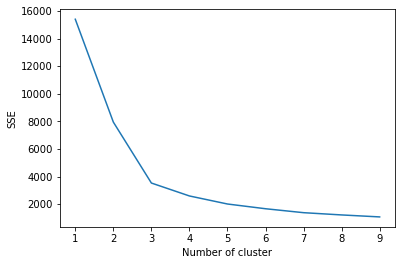

In [55]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


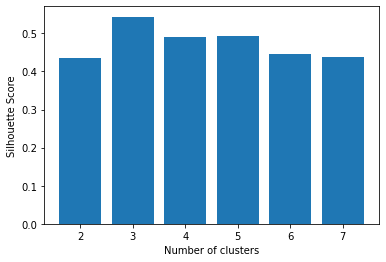

In [56]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

In [57]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_principal)

KMeans(n_clusters=3)

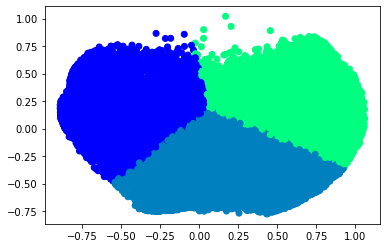

In [58]:
# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = KMeans(n_clusters = 3).fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

In [59]:
### What are centroids of the above cluster configuration

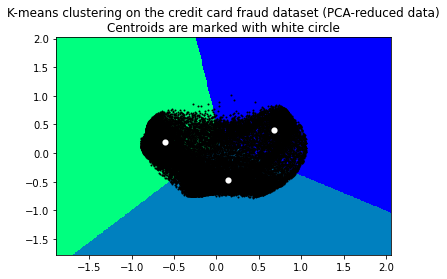

In [60]:
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_principal['P1'].min() - 1, X_principal['P1'].max() + 1
y_min, y_max = X_principal['P2'].min() - 1, X_principal['P2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.

Z = kmeans.predict(np.array(list(zip(xx.ravel(), yy.ravel()))))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
# https://stackoverflow.com/questions/16661790/difference-between-plt-close-and-plt-clf
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.winter,
           aspect='auto', origin='lower')

plt.plot(X_principal['P1'], X_principal['P2'], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='o', s=10, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the credit card fraud dataset (PCA-reduced data)\n'
          'Centroids are marked with white circle')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

## ANAMOLIES

### 1 - Billed amount is greater than the balance limit - Need to check if these customers are using the over limit facility.. Count is high


In [61]:
bill_1 = pd.concat([credit["BILLSEP"], credit["BALLIMIT"]], axis =1)

credit[bill_1["BILLSEP"] > bill_1["BALLIMIT"]].shape

(2115, 28)

### 2 - Billed amount is less than the pay amount and still defaulted, Was any payment made for the previous month pending.. If yes, why the same was not reflected in the billed amount

In [62]:
bill_1 = pd.concat([credit["BILLSEP"], credit["PAYSEP"]], axis =1)

credit[(bill_1["BILLSEP"] < bill_1["PAYSEP"]) & (credit["DEFAULT"] ==1 )].shape

(651, 28)

### 3 Total Pay Amount is greater than Bill Amount, still defaulted

In [63]:
credit['BILL_AMT']=credit['BILLSEP']+credit['BILLAUG']+credit['BILLJUL']+credit['BILLJUNE']+credit['BILLMAY']+credit['BILLAPR']
credit['PAY_AMT']=credit['PAYSEP']+credit['PAYAUG']+credit['PAYJUL']+credit['PAYJUNE']+credit['PAYMAY']+credit['PAYAPR']


In [64]:
credit.head()

,BALLIMIT,GENDER,EDUCATION,MARITAL_S,AGE,PAYSEPFL,PAYAUGFL,PAYJULFL,PAYJUNEFL,PAYMAYFL,PAYAPRFL,BILLSEP,BILLAUG,BILLJUL,BILLJUNE,BILLMAY,BILLAPR,PAYSEP,PAYAUG,PAYJUL,PAYJUNE,PAYMAY,PAYAPR,DEFAULT,RISK_VALUE,BILL_VALUE,BILL_PAY_VALUE,PAY_VALUE,BILL_AMT,PAY_AMT
0,20000,0,3,0,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,-2,1284.000000,-620.4,114.833333,7704,689
1,120000,0,3,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,3,2846.166667,-2279.0,833.333333,17077,5000
2,90000,0,3,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,16942.166667,-13279.2,1836.333333,101653,11018
3,50000,0,3,0,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,38555.666667,-35391.2,1398.000000,231334,8388
4,50000,1,3,0,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,-2,18223.166667,-8470.4,9841.500000,109339,59049


In [65]:
credit[(credit['PAY_AMT'] > credit['BILL_AMT']) & (credit['DEFAULT']==1)].shape

(495, 30)

- 495 customers are classified as defaulters even after paying the excess amount ??? 